<a href="https://colab.research.google.com/github/SUYAMBULAKSHMI-VENKATESAN/DAMAKA/blob/main/Segmentation_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

+---------------------+--------------+----------------+--------+-----------+
| Technique           | Parameters   | Library        |   Mean |   Std Dev |
+=====================+==============+================+========+===========+
| Blurred Image       | (5, 5)       | -              |  98.23 |     29.66 |
+---------------------+--------------+----------------+--------+-----------+
| K-Means             | k=2          | sklearn KMeans | 161.21 |    122.96 |
+---------------------+--------------+----------------+--------+-----------+
| FCM (Not Installed) | k=2          | skfuzzy cmeans |   0    |      0    |
+---------------------+--------------+----------------+--------+-----------+


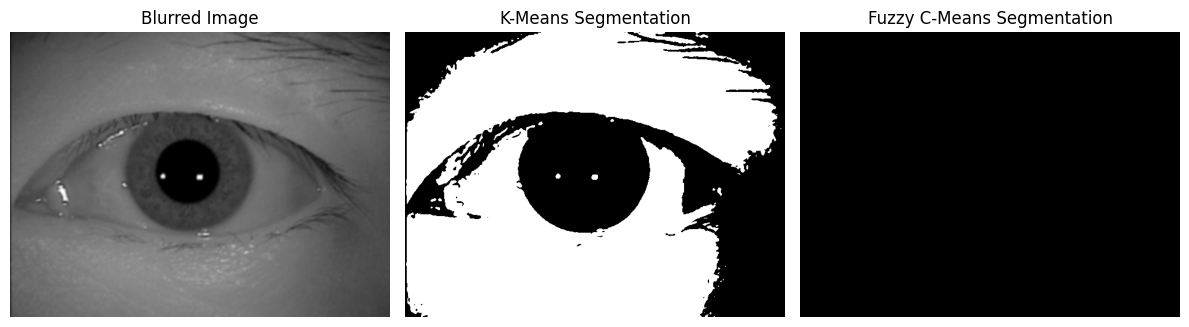

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tabulate import tabulate
try:
    import skfuzzy as fuzz
    fuzzy_available = True
except ImportError:
    fuzzy_available = False

def apply_clustering_segmentation(image_path):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    # Preprocessing: Gaussian Blur
    blur_kernel_size = (5, 5)
    blurred = cv2.GaussianBlur(image, blur_kernel_size, 0)

    # Flatten the image for clustering
    pixel_values = blurred.reshape((-1, 1)).astype(np.float32)

    # K-Means clustering
    k = 2
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pixel_values)
    kmeans_labels = kmeans.labels_.reshape(blurred.shape)
    kmeans_segmented = (kmeans_labels * (255 // (k - 1))).astype(np.uint8)

    # Fuzzy C-Means clustering (if available)
    if fuzzy_available:
        pixel_values_fcm = pixel_values.T  # shape should be [features, samples]
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            pixel_values_fcm, c=k, m=2, error=0.005, maxiter=1000, init=None)
        fcm_labels = np.argmax(u, axis=0)
        fcm_segmented = (fcm_labels.reshape(blurred.shape) * (255 // (k - 1))).astype(np.uint8)
    else:
        fcm_segmented = np.zeros_like(blurred)

    # Metrics Table
    table_data = [
        ["Blurred Image", str(blur_kernel_size), "-", f"{np.mean(blurred):.2f}", f"{np.std(blurred):.2f}"],
        ["K-Means", f"k={k}", "sklearn KMeans", f"{np.mean(kmeans_segmented):.2f}", f"{np.std(kmeans_segmented):.2f}"],
        ["FCM" if fuzzy_available else "FCM (Not Installed)", f"k={k}", "skfuzzy cmeans", f"{np.mean(fcm_segmented):.2f}", f"{np.std(fcm_segmented):.2f}"],
    ]

    headers = ["Technique", "Parameters", "Library", "Mean", "Std Dev"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    # Display Results
    titles = ["Blurred Image", "K-Means Segmentation", "Fuzzy C-Means Segmentation"]
    images = [blurred, kmeans_segmented, fcm_segmented]

    plt.figure(figsize=(12, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return table_data

# Example usage:
result = apply_clustering_segmentation("/content/S6000S00.jpg")
